In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import MinMaxScaler



In [2]:
btc = pd.read_csv('/Users/nikita/Desktop/monero/BTC.csv')

In [3]:
btc['close'] = btc['close'].str.replace('.', '')
btc['high'] = btc['high'].str.replace('.', '')
btc['low'] = btc['low'].str.replace('.', '')
btc['open'] = btc['open'].str.replace('.', '')
btc['volume'] = btc['volume'].str.replace('.', '')

btc['close'] = btc['close'].str.replace(',', '.').astype(float)
btc['high'] = btc['high'].str.replace(',', '.').astype(float)
btc['low'] = btc['low'].str.replace(',', '.').astype(float)
btc['open'] = btc['open'].str.replace(',', '.').astype(float)
btc['volume'] = btc['volume'].str.replace(',', '.')  # Remove commas

btc['volume'] = btc['volume'].str.replace('K', 'e3')  # Replace 'K' with 'e3'
btc['volume'] = btc['volume'].str.replace('M', 'e6')  # Replace 'M' with 'e6'
btc['volume'] = btc['volume'].str.replace('B', 'e9')  # Replace 'B' with 'e9'
btc['volume'] = btc['volume'].astype(float)  # Convert to float

/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_11176/493286543.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  btc['close'] = btc['close'].str.replace('.', '')
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_11176/493286543.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  btc['high'] = btc['high'].str.replace('.', '')
/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_11176/493286543.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  btc['low'] = btc['low'].str.replace('.', '')
/var

In [4]:
btc

date    close     high      low     open   volume
0     27.09.2012     12.3     12.3     12.4     12.2  19330.0
1     28.09.2012     12.4     12.3     12.4     12.1  26680.0
2     29.09.2012     12.4     12.4     12.5     12.2  17060.0
3     30.09.2012     12.4     12.4     12.4     12.3   7790.0
4     01.10.2012     12.4     12.4     12.5     12.3  24830.0
...          ...      ...      ...      ...      ...      ...
4591  23.04.2025  93697.7  93442.2  94462.6  91963.4  90350.0
4592  24.04.2025  93980.3  93696.3  94001.0  91673.0  66680.0
4593  25.04.2025  94676.9  93979.4  95718.6  92867.2  92040.0
4594  26.04.2025  94631.4  94669.3  95207.0  93891.8  33770.0
4595  27.04.2025  93873.1  94631.4  95324.4  93640.7  35890.0

[4596 rows x 6 columns]

In [5]:
stock_data = btc['close']

**DOWNLOAD DATASETS**



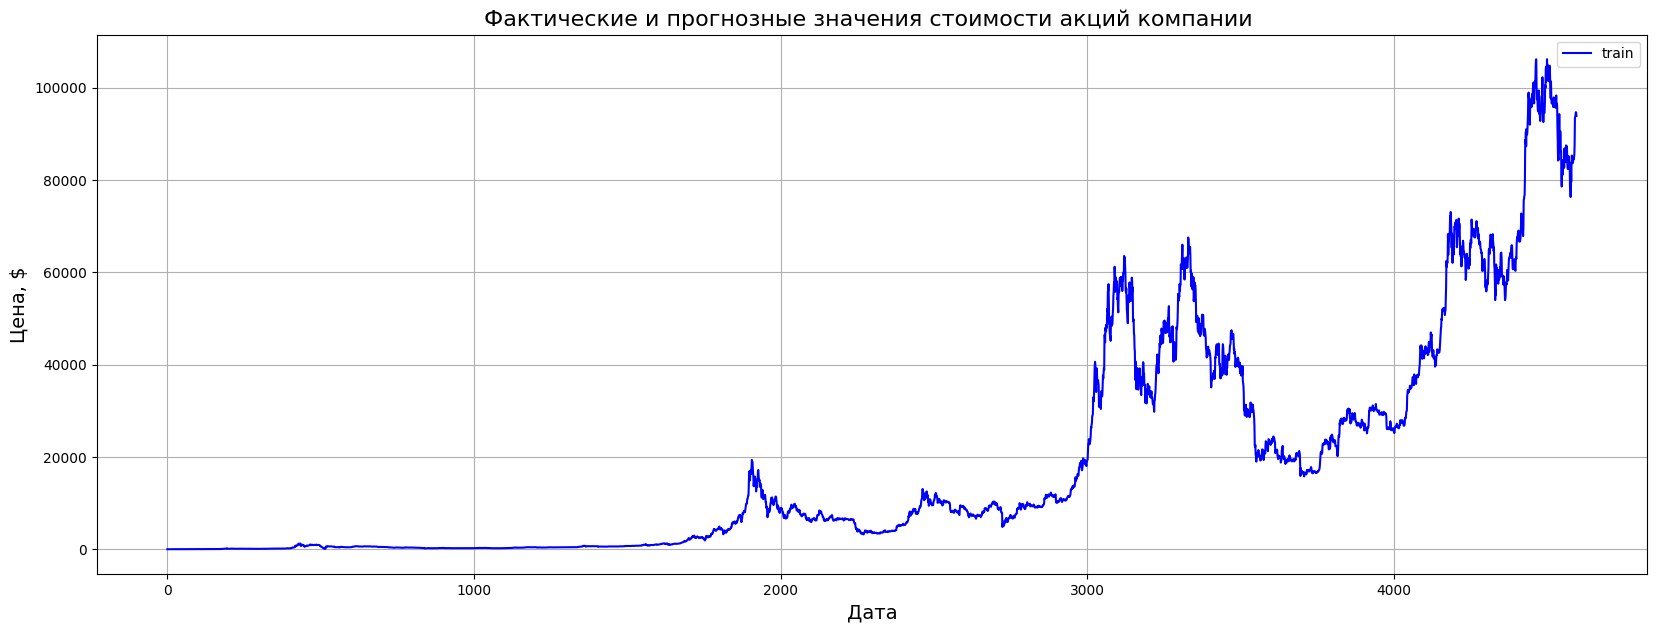

In [6]:
plt.figure(figsize=(20,7))
plt.plot(stock_data, color = 'blue', label='train')
plt.legend()
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Цена, $', fontsize = 14)
plt.grid()
plt.title('Фактические и прогнозные значения стоимости акций компании ', fontsize = 16)
plt.show()

**RESEARCH BTC**

In [7]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox


In [8]:
result = adfuller(btc['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.04796933275908125
p-value: 0.9543806541735955


In [9]:
# btc_diff = btc['open'].diff().dropna()  # удаляем NaN после diff

In [10]:
# # Предположим, что data - это ваш DataFrame
# btc_diff.plot(figsize=(10, 6), title='btc_diff', grid=True)
# plt.xlabel('Дата или индекс')
# plt.ylabel('Цена (open)')
# plt.show()

In [11]:
# result = adfuller(btc_diff)
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])

In [12]:
transformed_data, lambda_ = boxcox(btc['open'])  

print(f"Оптимальное λ: {lambda_:.3f}")

Оптимальное λ: 0.136


In [13]:
btc['transformed_data'] = transformed_data

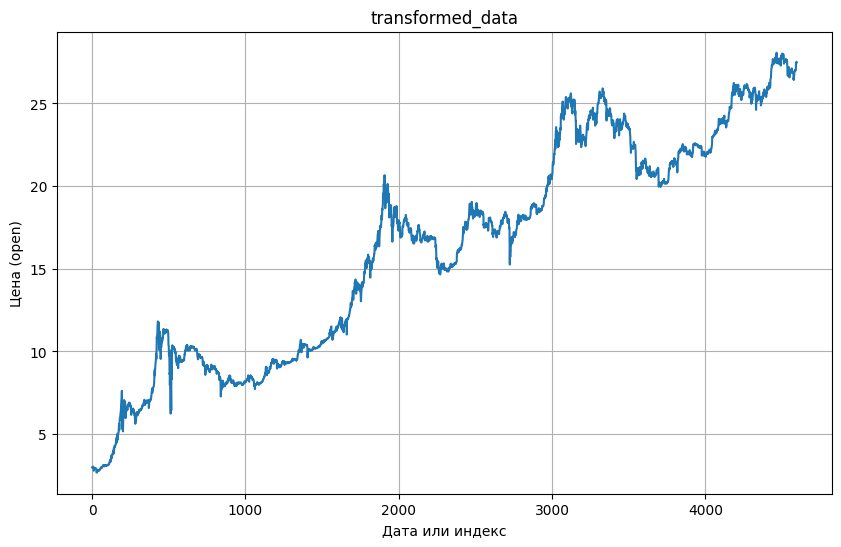

In [14]:
btc['transformed_data'].plot(figsize=(10, 6), title='transformed_data', grid=True)
plt.xlabel('Дата или индекс')
plt.ylabel('Цена (open)')
plt.show()

In [15]:
btc_diff = btc['transformed_data'].diff().dropna()  # удаляем NaN после diff

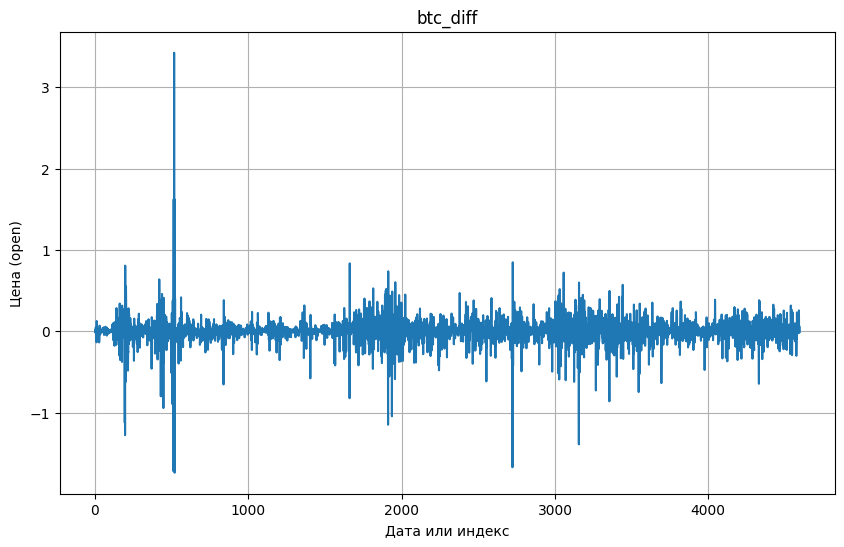

In [16]:
btc_diff.plot(figsize=(10, 6), title='btc_diff', grid=True)
plt.xlabel('Дата или индекс')
plt.ylabel('Цена (open)')
plt.show()

In [17]:
result = adfuller(btc_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -15.91093860282782
p-value: 8.125136566236626e-29


### Тренды и сезонность

In [18]:
btc['date'] = pd.to_datetime(btc['date'], format='%d.%m.%Y')
btc.set_index('date', inplace=True)

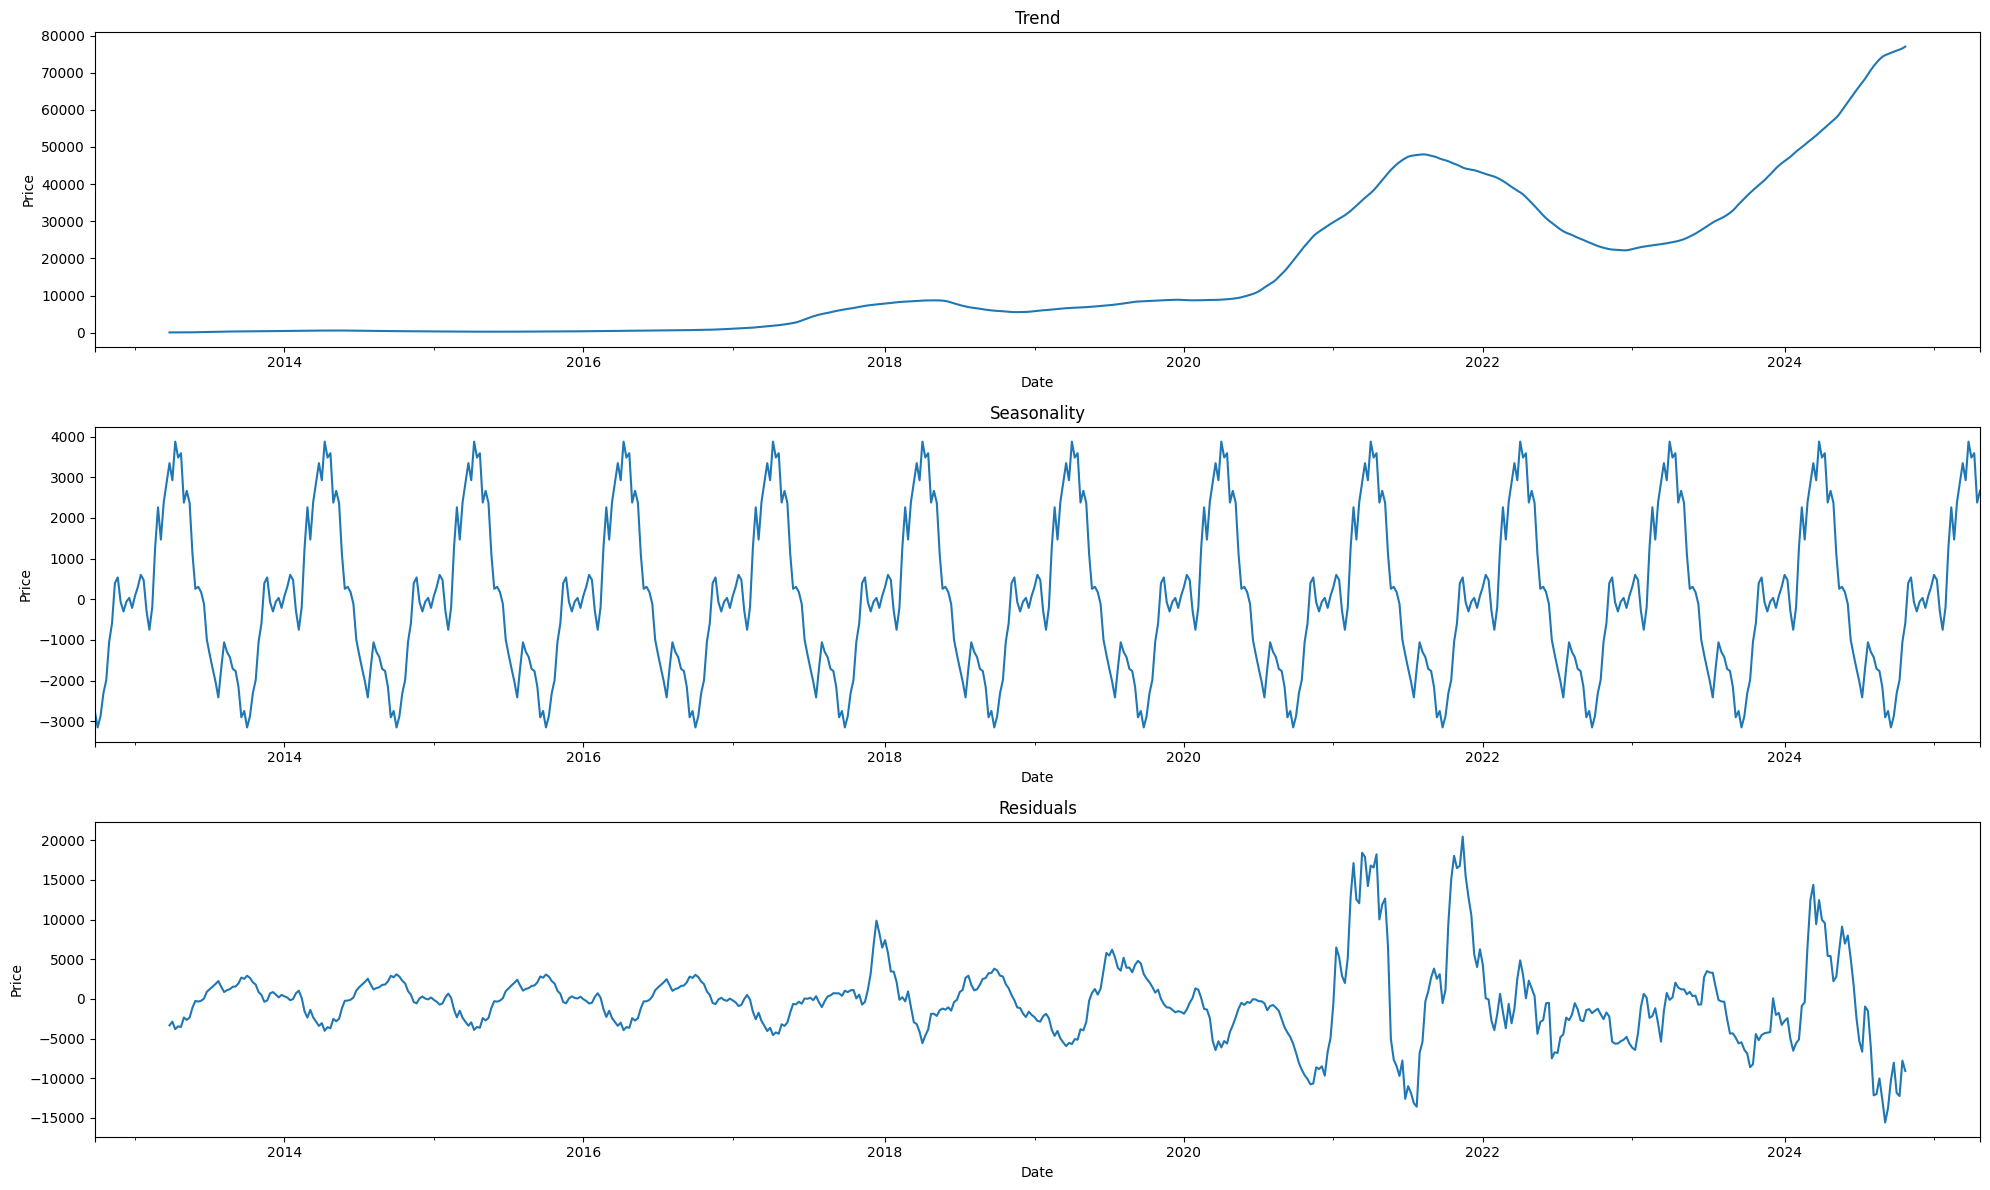

In [19]:
#Рассмотрим недельные данные, выполним ресемплирование ряда по 1 неделе
df_week = btc['close'].resample('1W').mean()

#Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df_week)



# Построим графики этих составляющих ряда
plt.figure(figsize=(20, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()

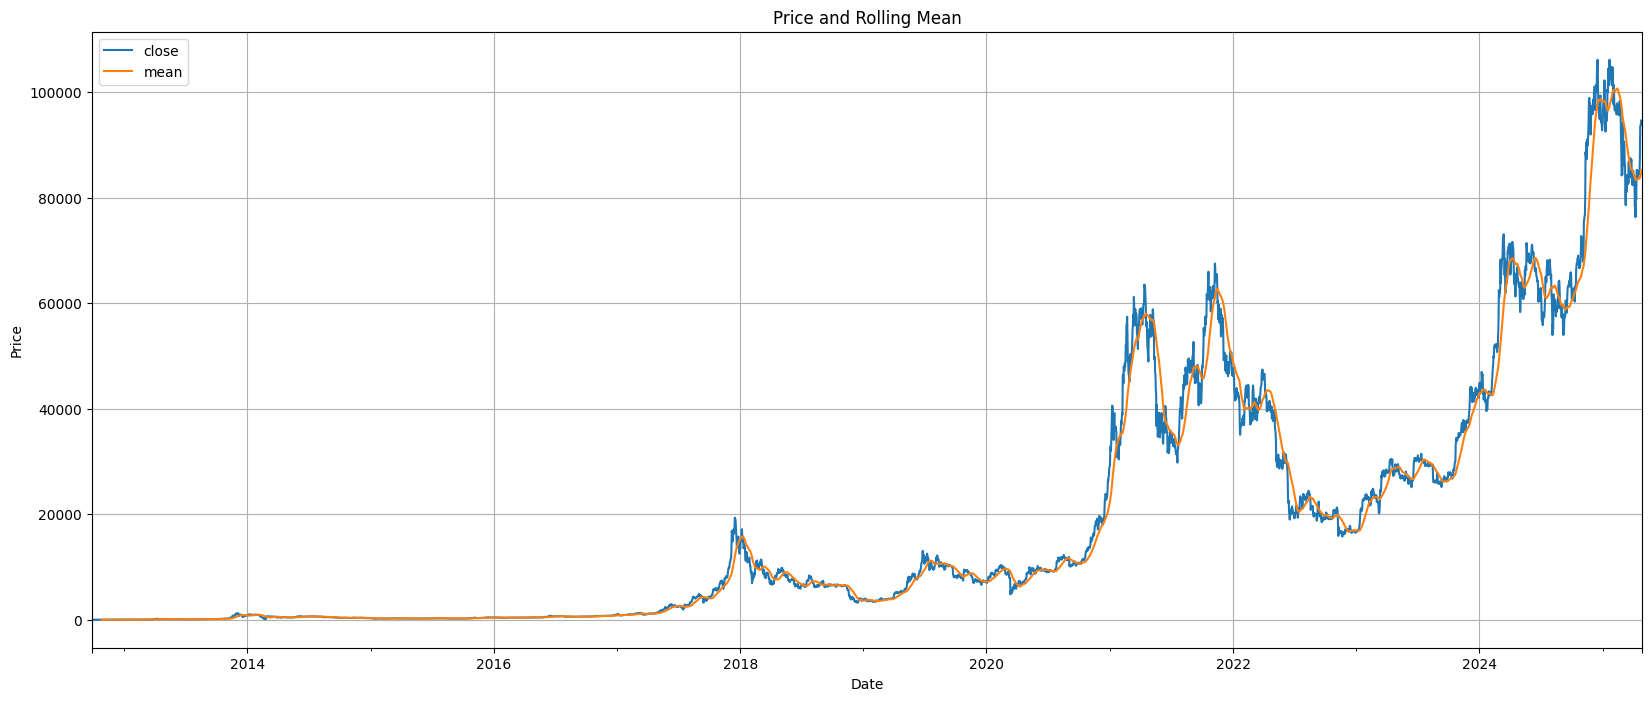

In [20]:
# Найдем скользящее среднее по ширине окна 30 дней
btc['mean'] = btc['close'].rolling(window=30).mean()

# Plot the price and rolling mean
btc[['close', 'mean']].plot(figsize=(20, 8))
plt.title('Price and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

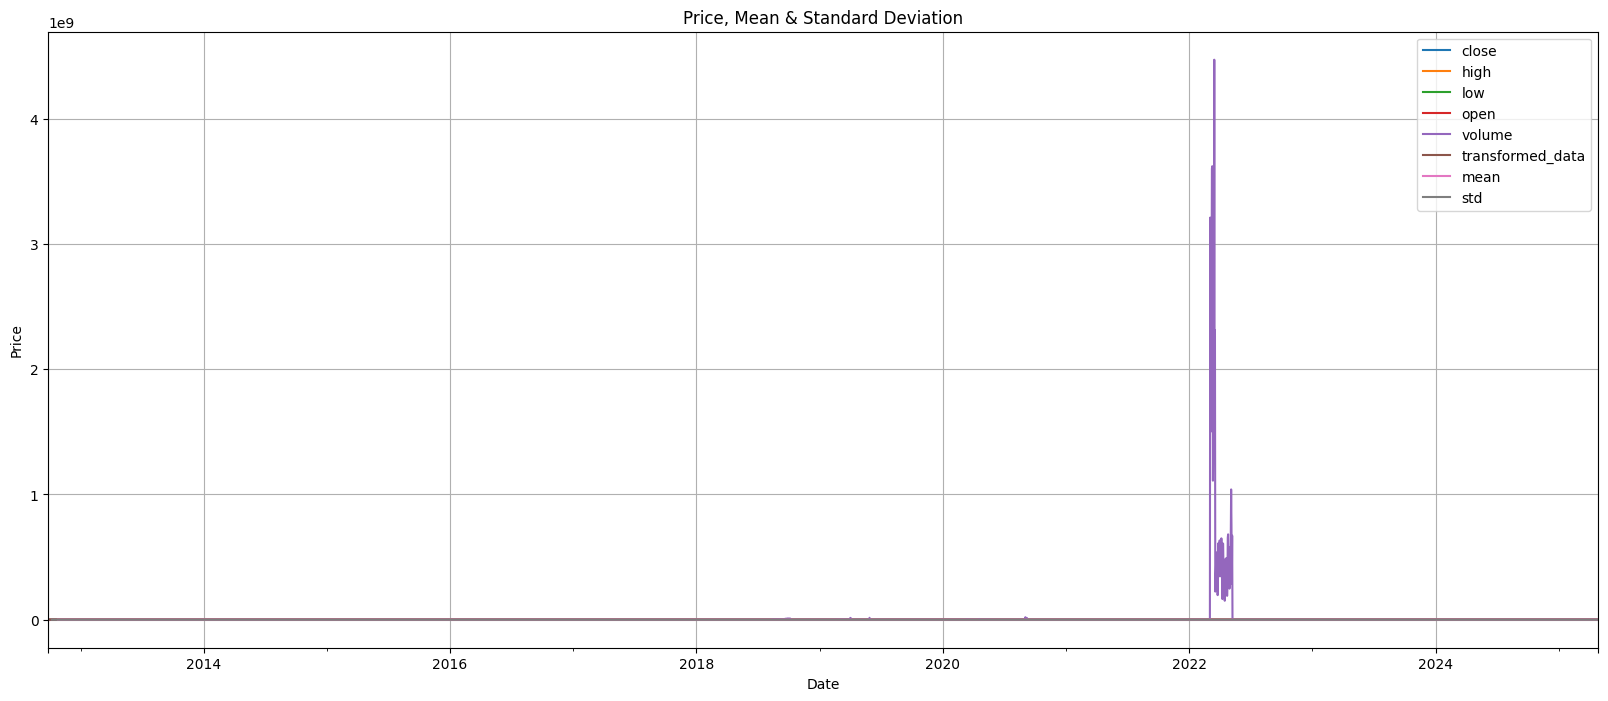

In [34]:
# Найдем скользящее стандартное отклонение по ширине окна 30 дней
# и построим график исходного временного ряда, скользящего среднего и скользящего стандартного отклонения
btc['std'] = btc['close'].shift().rolling(window=10).std()

btc.plot(figsize=(20, 8))
plt.title('Price, Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

### Разности временного ряда

In [23]:
# ряд первых разностей временного ряда
df_shift =btc - btc.shift(fill_value=0)

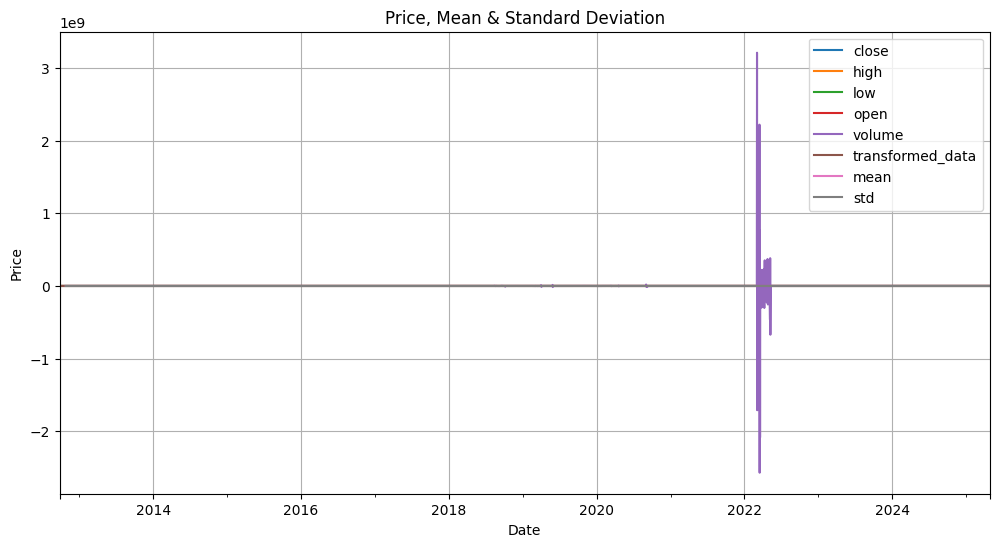

In [24]:
#скользящее среднее и скользящее стандартное отклонение ряда первых разностей

df_shift['mean'] = df_shift['close'].shift().rolling(30).mean()
df_shift['std'] = df_shift['close'].shift().rolling(30).std()

# график первых разностей временного ряда, его скользящего среднего
# и скользящего стандартного отклонения
df_shift.plot(figsize=(12, 6))
plt.title('Price, Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

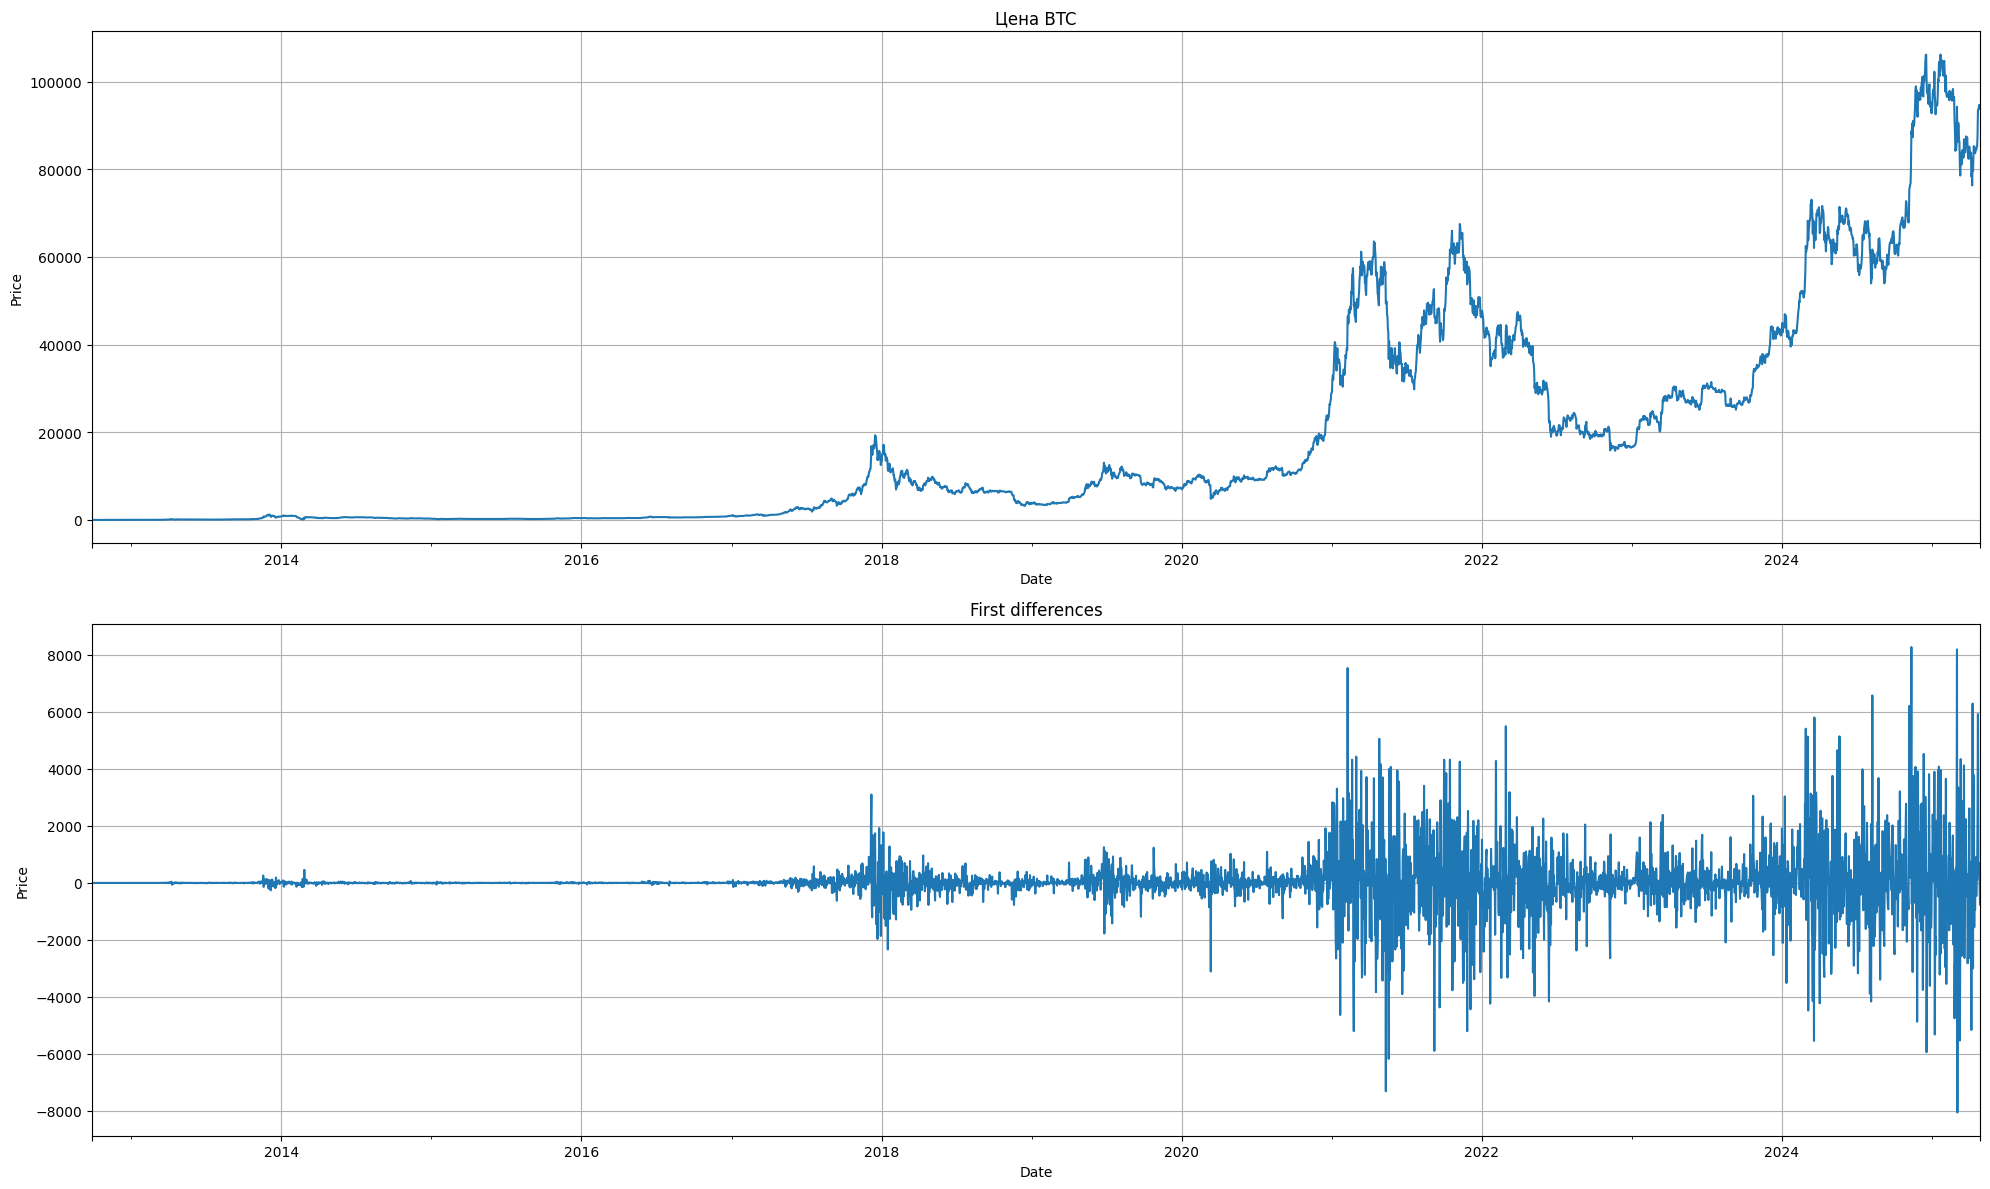

In [25]:
# Построим графики исходного временного ряда и его первых разностей
plt.figure(figsize=(20, 12))
plt.subplot(211)
btc['close'].plot(ax=plt.gca())
plt.title('Цена BTC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

plt.subplot(212)
df_shift['close'].plot(ax=plt.gca())
plt.title('First differences')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

plt.tight_layout()

<Figure size 2400x1200 with 0 Axes>

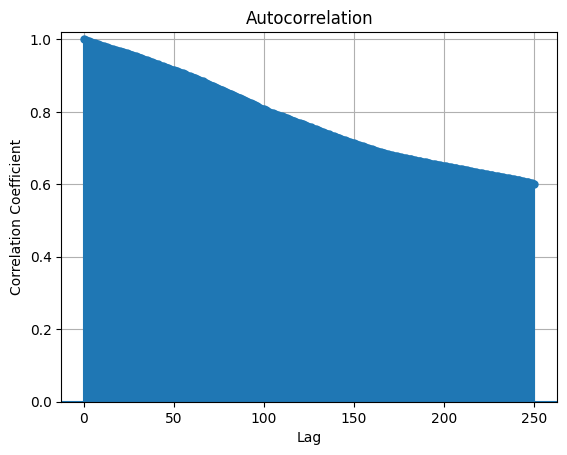

In [26]:
#График автокорреляционной функции при лаге 250
plt.figure(figsize=(24, 12))
plot_acf(btc["close"], lags = 250)
plt.xlabel('Lag')
plt.ylabel('Сorrelation Сoefficient')
#plt.xlim([0, 100.02])
plt.ylim([0, 1.02])
plt.grid()
plt.show()

In [27]:
# Проведем тест Дики-Фуллера
test = adfuller(btc["close"])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен при 5% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 5% уровне значимости')

if test[0]> test[4]['1%']:
    print('есть единичные корни, ряд не стационарен при 1% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 1% уровне значимости')

adf:  -0.04796933275908125
p-value:  0.9543806541735955
Critical values:  {'1%': -3.4317836068640415, '5%': -2.8621734858933445, '10%': -2.567107207596163}
есть единичные корни, ряд не стационарен при 5% уровне значимости
есть единичные корни, ряд не стационарен при 1% уровне значимости


### Создание новых признаков

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    data_new['month'] = data.index.month

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['close'].shift(lag)

    data_new['rolling_mean'] = data_new['close'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [29]:
# Включим в модель значения с лагом 14 и скользящее среднее по ширине окна 30.
# Применим функцию make_features и создадим новый датасет df_new
df_new = make_features(btc, max_lag = 28, rolling_mean_size = 50)
df_new.head()

close  high   low  open   volume  transformed_data  mean  day  \
date                                                                        
2012-09-27   12.3  12.3  12.4  12.2  19330.0          2.979084   NaN   27   
2012-09-28   12.4  12.3  12.4  12.1  26680.0          2.967529   NaN   28   
2012-09-29   12.4  12.4  12.5  12.2  17060.0          2.979084   NaN   29   
2012-09-30   12.4  12.4  12.4  12.3   7790.0          2.990558   NaN   30   
2012-10-01   12.4  12.4  12.5  12.3  24830.0          2.990558   NaN    1   

            dayofweek  month  ...  lag_20  lag_21  lag_22  lag_23  lag_24  \
date                          ...                                           
2012-09-27          3      9  ...     NaN     NaN     NaN     NaN     NaN   
2012-09-28          4      9  ...     NaN     NaN     NaN     NaN     NaN   
2012-09-29          5      9  ...     NaN     NaN     NaN     NaN     NaN   
2012-09-30          6      9  ...     NaN     NaN     NaN     NaN     NaN   
2012-10-01          0     10  ...     NaN     NaN     NaN     NaN     NaN   

            lag_25  lag_26  lag_27  lag_28  rolling_mean  
date                                                      
2012-09-27     NaN     NaN     NaN     NaN           NaN  
2012-09-28     NaN     NaN     NaN     NaN           NaN  
2012-09-29     NaN     NaN     NaN     NaN           NaN  
2012-09-30     NaN     NaN     NaN     NaN           NaN  
2012-10-01     NaN     NaN     NaN     NaN           NaN  

[5 rows x 39 columns]

In [30]:
btc['open'] = btc['open'].shift(1)
btc['close'] = btc['close'].shift(1)

In [44]:
df_new = df_new.dropna()

In [49]:
df_new = df_new.drop('mean', axis=1)

In [50]:
# Удалим столбцы 'mean', 'std', которые были ранее добавлены для посторения графиков.
# df_new.drop(['mean', 'std'], axis=1, inplace= True)
# df_new.drop(['high', 'low'], axis=1, inplace= True)

In [51]:
df_new.columns

Index(['close', 'high', 'low', 'open', 'volume', 'transformed_data', 'day',
       'dayofweek', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26',
       'lag_27', 'lag_28', 'rolling_mean'],
      dtype='object')

In [52]:
df_new

close     high      low     open   volume  transformed_data  \
date                                                                        
2012-11-16     11.8     11.2     11.8     11.2  58250.0          2.859639   
2012-11-17     11.8     11.8     11.8     11.5  19110.0          2.896409   
2012-11-18     11.6     11.8     11.8     11.6  15510.0          2.908482   
2012-11-19     11.8     11.6     11.8     11.6  25200.0          2.908482   
2012-11-20     11.7     11.8     11.8     11.6  27220.0          2.908482   
...             ...      ...      ...      ...      ...               ...   
2025-04-23  93697.7  93442.2  94462.6  91963.4  90350.0         27.417408   
2025-04-24  93980.3  93696.3  94001.0  91673.0  66680.0         27.402466   
2025-04-25  94676.9  93979.4  95718.6  92867.2  92040.0         27.463652   
2025-04-26  94631.4  94669.3  95207.0  93891.8  33770.0         27.515609   
2025-04-27  93873.1  94631.4  95324.4  93640.7  35890.0         27.502922   

            day  dayofweek  month    lag_1  ...   lag_20   lag_21   lag_22  \
date                                        ...                              
2012-11-16   16          4     11     11.2  ...     10.3     10.2     10.9   
2012-11-17   17          5     11     11.8  ...     10.7     10.3     10.2   
2012-11-18   18          6     11     11.8  ...     10.6     10.7     10.3   
2012-11-19   19          0     11     11.6  ...     10.9     10.6     10.7   
2012-11-20   20          1     11     11.8  ...     11.2     10.9     10.6   
...         ...        ...    ...      ...  ...      ...      ...      ...   
2025-04-23   23          2      4  93441.9  ...  83159.4  82525.0  85164.2   
2025-04-24   24          3      4  93697.7  ...  83866.7  83159.4  82525.0   
2025-04-25   25          4      4  93980.3  ...  83552.1  83866.7  83159.4   
2025-04-26   26          5      4  94676.9  ...  78391.3  83552.1  83866.7   
2025-04-27   27          6      4  94631.4  ...  79162.5  78391.3  83552.1   

             lag_23   lag_24   lag_25   lag_26   lag_27   lag_28  rolling_mean  
date                                                                            
2012-11-16     11.6     11.6     11.7     11.6     11.7     11.7        11.512  
2012-11-17     10.9     11.6     11.6     11.7     11.6     11.7        11.502  
2012-11-18     10.2     10.9     11.6     11.6     11.7     11.6        11.490  
2012-11-19     10.3     10.2     10.9     11.6     11.6     11.7        11.474  
2012-11-20     10.7     10.3     10.2     10.9     11.6     11.6        11.462  
...             ...      ...      ...      ...      ...      ...           ...  
2025-04-23  82548.8  82371.6  82645.7  84410.4  87228.2  86912.0     84217.494  
2025-04-24  85164.2  82548.8  82371.6  82645.7  84410.4  87228.2     84346.122  
2025-04-25  82525.0  85164.2  82548.8  82371.6  82645.7  84410.4     84413.494  
2025-04-26  83159.4  82525.0  85164.2  82548.8  82371.6  82645.7     84508.414  
2025-04-27  83866.7  83159.4  82525.0  85164.2  82548.8  82371.6     84670.418  

[4546 rows x 38 columns]

In [53]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.01)
train = train.dropna()

print(train.shape)

print(test.shape)
print(train.index.min(), train.index.max())

print(test.index.min(), test.index.max())

(4500, 38)
(46, 38)
2012-11-16 00:00:00 2025-03-12 00:00:00
2025-03-13 00:00:00 2025-04-27 00:00:00


In [ ]:
X_train = train.drop(['close'], axis=1)
y_train = train['close']

X_test = test.drop(['close'], axis=1)
y_test = test['close']

## Обучение моделей

In [ ]:
def calculate_metrics(y_true, y_pred):
    """Calculates MSE, RMSE, MAE, and MAPE."""

    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))

    # Handle potential division by zero in MAPE calculation
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    mape = np.nan_to_num(mape) #Replaces nan with 0

    return mse, rmse, mae, mape


In [ ]:
# Словать с метриками для обучения моделей
scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

In [ ]:
# Определяем тип кросс-валидаци на временных рядах
tscv = TimeSeriesSplit(n_splits=10)

In [ ]:
model = LinearRegression()

In [ ]:
X_test

open    volume  transformed_data  day  dayofweek  month  \
date                                                                     
2025-03-13  79954.9   79250.0         26.762444   13          3      3   
2025-03-14  80833.2   81230.0         26.813134   14          4      3   
2025-03-15  83636.4   38400.0         26.971795   15          5      3   
2025-03-16  82014.2   50040.0         26.880550   16          6      3   
2025-03-17  82525.0   58040.0         26.909448   17          0      3   
2025-03-18  81171.3   58170.0         26.832521   18          1      3   
2025-03-19  82557.5   84610.0         26.911281   19          2      3   
2025-03-20  83656.1   69860.0         26.972894   20          3      3   
2025-03-21  83215.9   42800.0         26.948291   21          4      3   
2025-03-22  83688.2   20840.0         26.974683   22          5      3   
2025-03-23  83812.7   31130.0         26.981619   23          6      3   
2025-03-24  85541.6   95710.0         27.077026   24          0      3   
2025-03-25  86328.5   75240.0         27.119899   25          1      3   
2025-03-26  85866.4   62040.0         27.094764   26          2      3   
2025-03-27  85844.4   56490.0         27.093564   27          3      3   
2025-03-28  83596.7   85250.0         26.969580   28          4      3   
2025-03-29  81668.2   39340.0         26.860886   29          5      3   
2025-03-30  81593.2   35370.0         26.856614   30          6      3   
2025-03-31  81300.1   61760.0         26.839888   31          0      3   
2025-04-01  82435.8   66720.0         26.904413    1          1      4   
2025-04-02  82358.9  104050.0         26.900068    2          2      4   
2025-04-03  81313.8   83150.0         26.840671    3          3      4   
2025-04-04  81691.1   91540.0         26.862190    4          4      4   
2025-04-05  82384.4   32710.0         26.901509    5          5      4   
2025-04-06  77171.1   79170.0         26.598537    6          6      4   
2025-04-07  74524.2  170570.0         26.437881    7          0      4   
2025-04-08  76255.0   93880.0         26.543480    8          1      4   
2025-04-09  74657.3  172180.0         26.446076    9          2      4   
2025-04-10  78495.8   92830.0         26.677160   10          3      4   
2025-04-11  79004.2   94620.0         26.707030   11          4      4   
2025-04-12  82828.0   55600.0         26.926517   12          5      4   
2025-04-13  83049.6   70930.0         26.938967   13          6      4   
2025-04-14  83705.2   78030.0         26.975631   14          0      4   
2025-04-15  83602.7   62450.0         26.969915   15          1      4   
2025-04-16  83143.5   63970.0         26.944233   16          2      4   
2025-04-17  83786.2   49280.0         26.980144   17          3      4   
2025-04-18  84331.0   25830.0         27.010398   18          4      4   
2025-04-19  84366.5   32070.0         27.012364   19          5      4   
2025-04-20  83976.1   32080.0         26.990709   20          6      4   
2025-04-21  85148.8   98500.0         27.055497   21          0      4   
2025-04-22  87105.2  130170.0         27.161887   22          1      4   
2025-04-23  91963.4   90350.0         27.417408   23          2      4   
2025-04-24  91673.0   66680.0         27.402466   24          3      4   
2025-04-25  92867.2   92040.0         27.463652   25          4      4   
2025-04-26  93891.8   33770.0         27.515609   26          5      4   
2025-04-27  93640.7   35890.0         27.502922   27          6      4   

              lag_1    lag_2    lag_3    lag_4  ...   lag_20   lag_21  \
date                                            ...                     
2025-03-13  83664.3  82921.1  78575.9  80691.6  ...  96155.6  98310.3   
2025-03-14  81100.2  83664.3  82921.1  78575.9  ...  96556.1  96155.6   
2025-03-15  83977.1  81100.2  83664.3  82921.1  ...  96258.8  96556.1   
2025-03-16  84341.3  83977.1  81100.2  83664.3  ...  91508.5  96258.8   
2025-03-17  82578.4  843

In [ ]:
start_time = time.time()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

lr_time = time.time() - start_time

In [ ]:
y_predict = pd.Series(y_predict, index=X_test.index)

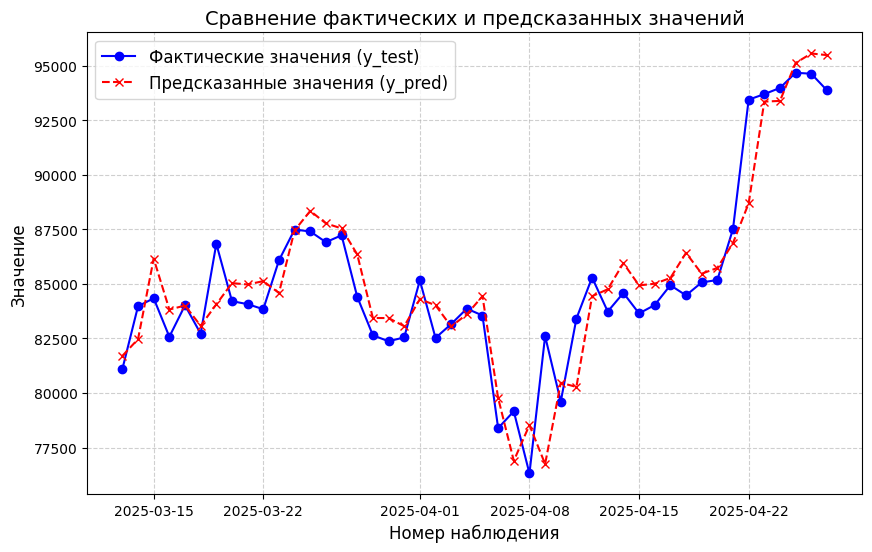

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_predict, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [ ]:
# Метрики
lr_mse, lr_rmse, lr_mae, lr_mape = calculate_metrics(y_test, y_predict)
print("MSE валидационной выборки:", lr_mse)
print("RMSE валидационной выборки:", lr_rmse)
print("MAE валидационной выборки:", lr_mae)
print("MAPE валидационной выборки:", lr_mape)

MSE валидационной выборки: 2754724.96301083
RMSE валидационной выборки: 1659.7364137147893
MAE валидационной выборки: 1232.3851842853685
MAPE валидационной выборки: 1.4554712764582554


Elastic

In [ ]:
# Используем GridSearch для подбора гиперпараметров модели
param_grid = {
    'alpha': [i*0.1 for i in range(0, 10, 1)],
    'l1_ratio': [i*0.1 for i in range(0, 10, 1)]
}


In [ ]:
Elastic = GridSearchCV(ElasticNet(random_state=12345), param_grid, cv=tscv, scoring='neg_root_mean_squared_error').fit(X_train, y_train)

/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.228e+04, tolerance: 2.579e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/Ridg

KeyboardInterrupt: 

In [ ]:
y_pred = Elastic.best_estimator_.predict(X_test)

In [ ]:
el_mse, el_rmse, el_mae, el_mape = calculate_metrics(y_test, y_pred)

print('Параметры лучшей модели', Elastic.best_params_)
print("MSE валидационной выборки:", el_mse)
print("RMSE валидационной выборки:", el_rmse)
print("MAE валидационной выборки:", el_mae)
print("MAPE валидационной выборки:", el_mape)

Параметры лучшей модели {'alpha': 0.9, 'l1_ratio': 0.9}
MSE валидационной выборки: 2018469.464082794
RMSE валидационной выборки: 1420.7284976668814
MAE валидационной выборки: 1086.9997186906921
MAPE валидационной выборки: 1.290679642262098


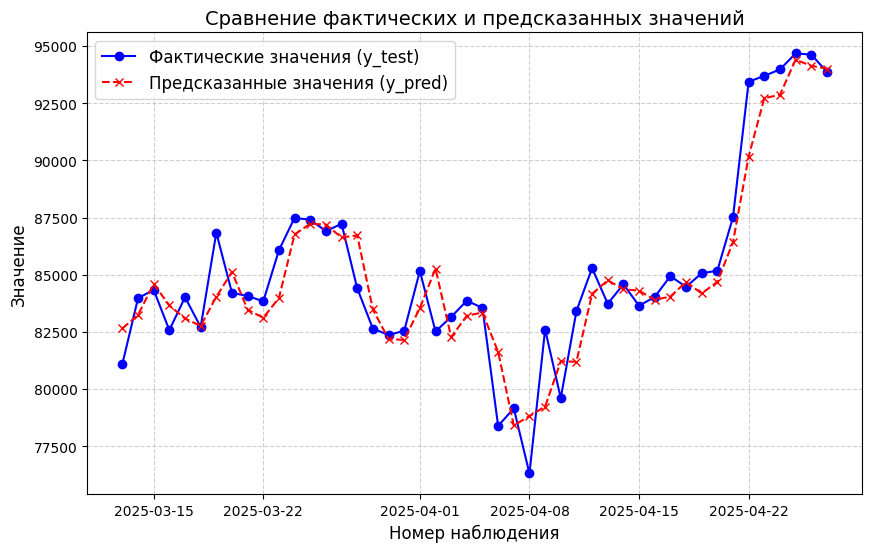

In [ ]:
y_pred = pd.Series(y_pred, index=X_test.index)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### Decision Tree

In [ ]:

# # Используем GridSearch для подбора гиперпараметров модели дерева решений
# param_grid={
#  'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
#   'splitter':['best','random'],
#   'max_depth':[1, 2, 3, 5, 10, 20, 30, 50],
#   'max_features':['auto', 'sqrt', 'log2'],
#   'min_samples_split': [1, 2, 5, 10, 20, 50, 100]
# # }

In [ ]:
# start_time = time.time()

# DecisionTree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=tscv,).fit(X_train, y_train)

# y_pred = DecisionTree.best_estimator_.predict(X_test)

# dt_time = time.time() - start_time

In [ ]:
# dt_mse, dt_rmse, dt_mae, dt_mape = calculate_metrics(y_test, y_pred)

In [ ]:
# # выведите лучшую метрику качества
# print('Параметры лучшей модели', DecisionTree.best_params_)
# print('RMSE  лучшей модели', dt_mse)
# print('MSE', dt_rmse)
# print('MAE', dt_mae)
# print('MAPE', dt_mape)

In [ ]:
# y_pred = pd.Series(y_pred, index=X_test.index)

# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
# plt.plot(y_pred, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# # Добавляем заголовки и легенду
# plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
# plt.xlabel('Номер наблюдения', fontsize=12)
# plt.ylabel('Значение', fontsize=12)
# plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)

# plt.show()

### K-ближайших соседей

In [ ]:
# инициализируем модель k ближайших соседей
knn = KNeighborsRegressor()

# Создайте словарь со значением гиперпараметров:
parameters = {
    'n_neighbors': range(1, 30),  #  количество соседей
    'weights': ['uniform', 'distance'], #  веса соседей
    'metric': ['euclidean', 'manhattan'] # метрики расстояния
}

# Инициализируйте класс для автоматизированного поиска:
# значение кросс-валидации tcvs, метрика rmse и n_jobs=-1.
start_time = time.time()

KNN = GridSearchCV(knn, parameters, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)


# выведите лучшие гиперпараметры
print('Гиперпараметры', KNN.best_params_)

# выведите лучшую метрику качества
y_pred = KNN.best_estimator_.predict(X_test)
knn_mse, knn_rmse, knn_mae, knn_mape = calculate_metrics(y_test, y_pred)
print('RMSE  лучшей модели', knn_rmse)
print('MSE', knn_mse)
print('MAE', knn_mae)
print('MAPE', knn_mape)

knn_time = time.time() - start_time

Гиперпараметры {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
RMSE  лучшей модели 3216.372648978283
MSE 10345053.017095577
MAE 2333.31318681831
MAPE 2.7306261977402504


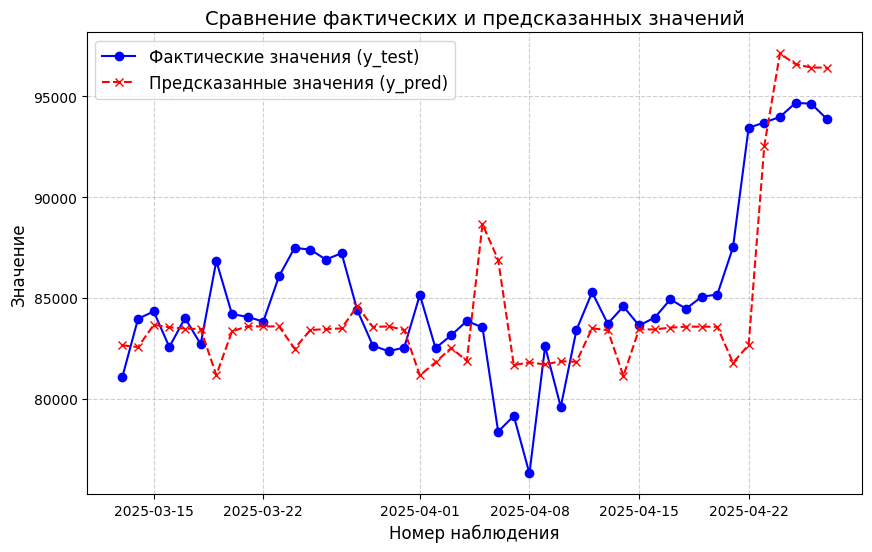

In [ ]:
y_pred = pd.Series(y_pred, index=X_test.index)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### Random Forest

In [ ]:
model = RandomForestRegressor()

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}



In [ ]:
RandomForest = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)
# выведите лучшие гиперпараметры
print('Гиперпараметры', RandomForest.best_params_)

start_time = time.time()
# выведите лучшую метрику качества
y_pred = RandomForest.best_estimator_.predict(X_test)
rf_mse, rf_rmse, rf_mae, rf_mape = calculate_metrics(y_test, y_pred)
print('RMSE  лучшей модели', rf_mse)
print('MSE', rf_rmse)
print('MAE', rf_mae)
print('MAPE', rf_mape)
rf_time = time.time() - start_time

Гиперпараметры {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE  лучшей модели 2308269.2217308106
MSE 1519.2989244157354
MAE 1135.9821237318743
MAPE 1.3597466838135464


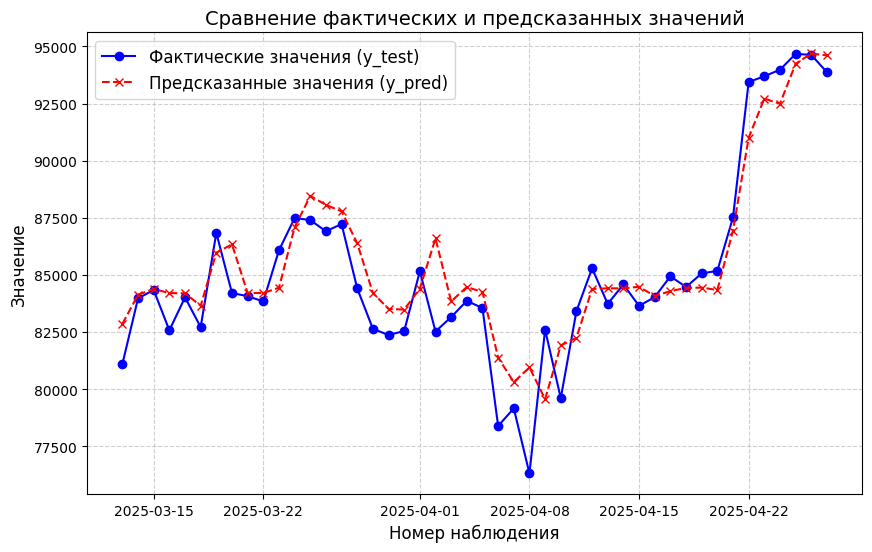

In [ ]:
y_pred = pd.Series(y_pred, index=X_test.index)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### LGBM_Regressor

In [ ]:
model = LGBMRegressor()

In [ ]:
# Определим набор гиперпараметров для кросс-валидации и используем GridSearch для их подбора
param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],  # Boosting types to try
    'num_leaves': [31, 63, 127],  # Number of leaves in each tree
    'learning_rate': [0.01, 0.1, 0.05],  # Learning rate
    'n_estimators': [100, 500, 1000],  # Number of boosting rounds
    'max_depth': [-1, 5, 10],  # Maximum tree depth (-1 means no limit)
    'min_child_samples': [20, 50, 100],  # Minimum samples required in a leaf node
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'subsample_freq': [0, 1],  # Frequence of subsample
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1],  # L2 regularization
}


In [ ]:
start_time = time.time()

LGBMR = RandomizedSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)

lgbmr_time = time.time() - start_time

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4710
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 37
[LightGBM] [Info] Number of data points in the train set: 819, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Start training f

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 1189, in fit
    super().fit(
  File "/Users/nikita/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
  File "/Users/nikita/Li

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8722
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 37
[LightGBM] [Info] Start training from score 17912.732110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [ ]:
# выведите лучшие гиперпараметры
print('Гиперпараметры', LGBMR.best_params_)

# выведите лучшую метрику качества
y_pred = LGBMR.best_estimator_.predict(X_test)
lgbmr_mse, lgbmr_rmse, lgbmr_mae, lgbmr_mape = calculate_metrics(y_test, y_pred)
print('RMSE  лучшей модели', lgbmr_mse)
print('MSE', lgbmr_rmse)
print('MAE', lgbmr_mae)
print('MAPE', lgbmr_mape)

Гиперпараметры {'subsample_freq': 1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 1, 'num_leaves': 31, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
RMSE  лучшей модели 4692439.873385675
MSE 2166.204023951963
MAE 1723.0832449395268
MAPE 2.0365397450600415


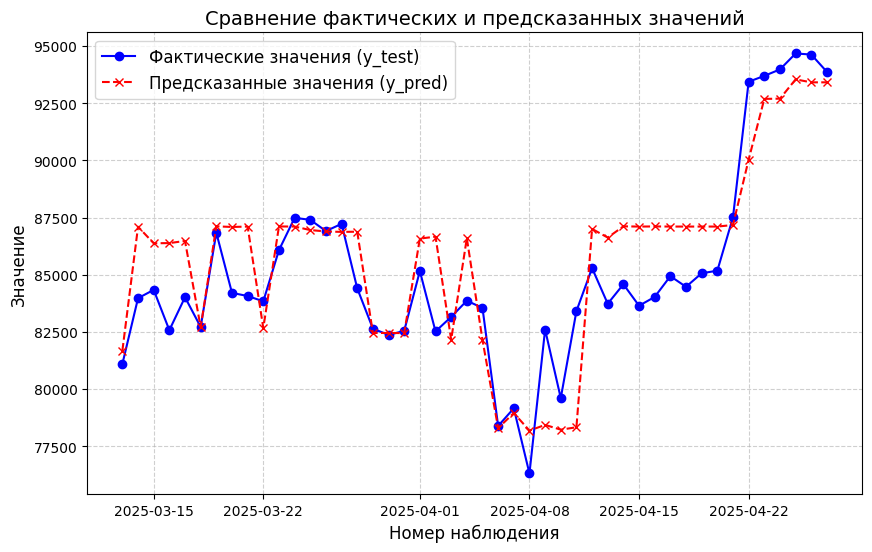

In [ ]:
y_pred = pd.Series(y_pred, index=X_test.index)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### Метод опорных векторов

In [ ]:
# # инициализируем модель SVC
# model = SVR()

# # Создайте словарь со значением гиперпараметров:
# parameters = {
#     'C': [0.1, 1, 10, 20, 30, 50, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# start_time = time.time()
# # Инициализируйте класс для автоматизированного поиска:
# # значение кросс-валидации tscv, метрика rmse и n_jobs=-1.
# Support_Vector_Classification = GridSearchCV(model, parameters, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1).fit(X_train, y_train)


# # выведите лучшие гиперпараметры
# print('Гиперпараметры', Support_Vector_Classification.best_params_)

# # выведите лучшую метрику качества
# y_pred = Support_Vector_Classification.best_estimator_.predict(X_test)
# svc_mse, svc_rmse, svc_mae, svc_mape = calculate_metrics(y_test, y_pred)
# print('RMSE  лучшей модели', svc_rmse)
# print('MSE', svc_mse)
# print('MAE', svc_mae)
# print('MAPE', svc_mape)
# svc_time = time.time() - start_time

In [ ]:
# y_pred = pd.Series(y_pred, index=X_test.index)

# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
# plt.plot(y_pred, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# # Добавляем заголовки и легенду
# plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
# plt.xlabel('Номер наблюдения', fontsize=12)
# plt.ylabel('Значение', fontsize=12)
# plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)

# plt.show()

# Сформируем по результатам обучения итоговую таблицу


In [ ]:
# Сформируем по результатам обучения итоговую таблицу
Results = pd.DataFrame({'Model' : ['Линейная регрессия', 'K ближайших соседей', 'Случайный лес', 'LGBM'],
                       'MSE на валидационной выборке': [lr_mse, knn_mse, rf_mse, lgbmr_mse],
                        'RMSE на валидационной выборке' : [lr_rmse, knn_rmse, rf_rmse, lgbmr_rmse],
                        'MAE на валидационной выборке': [lr_mae, knn_mae, rf_mae, lgbmr_mae],
                        'MAPE на валидационной выборке': [lr_mape, knn_mape, rf_mape, lgbmr_mape],
                       'Время обучения': [lr_time, knn_time, rf_time, lgbmr_time]
                        })

Results

Model  MSE на валидационной выборке  \
0   Линейная регрессия                  7.747866e+05   
1  K ближайших соседей                  1.034505e+07   
2        Случайный лес                  2.308269e+06   
3                 LGBM                  4.692440e+06   

   RMSE на валидационной выборке  MAE на валидационной выборке  \
0                     880.219640                    637.027423   
1                    3216.372649                   2333.313187   
2                    1519.298924                   1135.982124   
3                    2166.204024                   1723.083245   

   MAPE на валидационной выборке  Время обучения  
0                       0.755387        0.060979  
1                       2.730626        3.928524  
2                       1.359747        0.004860  
3                       2.036540       79.639561

# Прогнозирование с помощью рекуррентных блоков LSTM и GRU

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
#from keras.layers import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Initializing the Recurrent Neural Network
model = tensorflow.keras.Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 256, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.3))

model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 16))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

/Users/nikita/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 37, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 37, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 37, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 37, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 37, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,289 (2.01 MB)

 Trainable params: 526,289 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=10)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

hist = model.fit(X_train, y_train, epochs = 100, batch_size = 16, verbose = 1)#, validation_split = 0.20, callbacks = [early_stop]);

Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 870948224.0000 - mae: 18071.0879
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 903635072.0000 - mae: 18146.4375
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 914438848.0000 - mae: 18486.1934
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 886897216.0000 - mae: 18124.5000
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 876497792.0000 - mae: 17822.9551
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 896835648.0000 - mae: 18126.7422
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 894512064.0000 - mae: 18180.6875
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 808572672.0000 - mae: 17238.0840
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 898948096.0000 - mae: 18261.8770
Epoch 10/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 868207680.0000 - mae: 17766.7598
Epoch 11/100
282/282 ━━━━━━━━━━━━━━━━━━

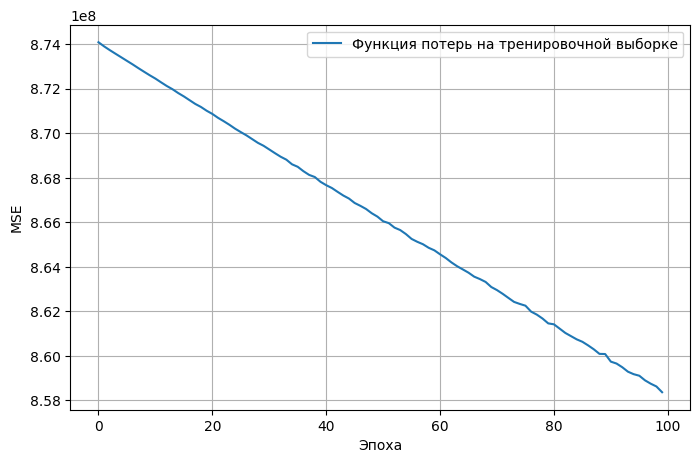

In [ ]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['loss'], label='Функция потерь на тренировочной выборке')
#plt.plot(hist.history['val_loss'], label='Функция потерь на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

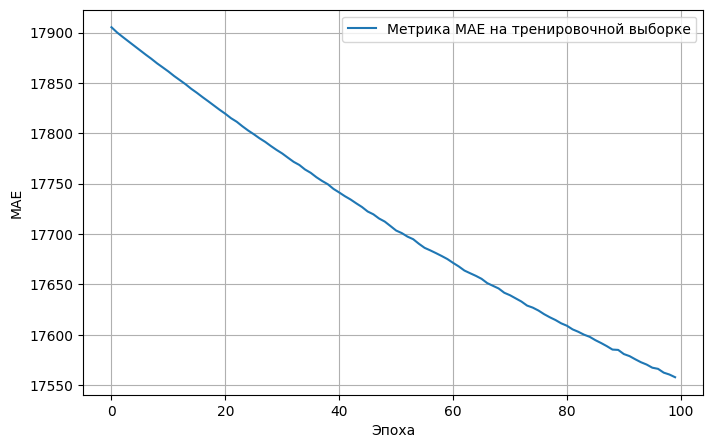

In [ ]:
plt.figure(figsize =(8, 5))
plt.plot(hist.history['mae'], label='Метрика MAE на тренировочной выборке')
#plt.plot(hist.history['val_mae'], label='Метрика MAE на валидационной выборке')

plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predict_LSTM = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


In [ ]:
print('MAE', mean_absolute_error(y_test, predict_LSTM))
print('MAPE', mean_absolute_percentage_error(y_test, predict_LSTM))
print('MSE', mean_squared_error(y_test, predict_LSTM))
print('RMSE', np.sqrt(mean_squared_error(y_test, predict_LSTM)))

MAE 84663.05552845831
MAPE 0.9946707095939249
MSE 7184840161.956647
RMSE 84763.43646854254


In [ ]:
y_pred = predict_LSTM.ravel()

# Now you can proceed with your operations
y_pred = pd.Series(y_pred, index=y_test.index)

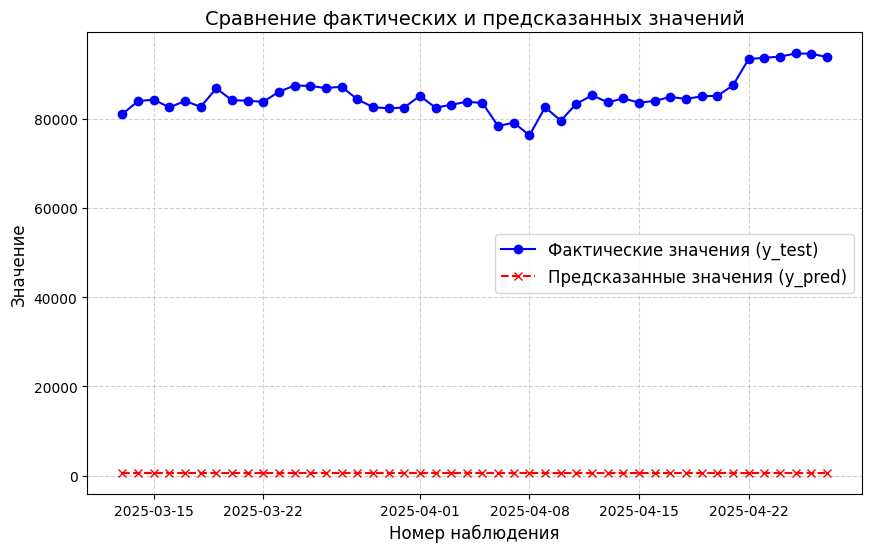

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Фактические значения (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='Предсказанные значения (y_pred)', marker='x', linestyle='--', color='red')

# Добавляем заголовки и легенду
plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()